In [1]:
import numpy as np
from typing import List, Tuple
from os import path, getcwd
import matplotlib.pyplot as plt
import random

Implement the simple EA for the TSP described in our first lecture (see slides).

In [2]:
cities_path = path.join(getcwd(), "file-tsp.txt")
ulysses_path = path.join(getcwd(), "ulysses16.txt")

candidate: List[int]

def get_fitness_func(distance_map:np.ndarray):
    """Helper-Function: Create a fitness function based on a table of distances"""
    def calc_dist(city_a:int, city_b:int):
        """Helper-Function: Calculate distance between cities a and b"""
        # Get the coordinates of city A
        x_a, y_a = distance_map[city_a]
        # Get the coordinates of city B
        x_b, y_b = distance_map[city_b]
        return abs(x_a-x_b)+abs(y_a-y_b)

    def get_travel_time(candidate: List[int]):
        """Calculate the total travel time of a candidate"""
        total_dist = 0
        # Loop over the candidate's sequence to retrieve the path and compute the total distance
        for i in range(0, len(candidate)-1):
            total_dist += calc_dist(candidate[i], candidate[i+1])
        return total_dist

    def eval_fitness(candidate: List[int]):  
        """Calculate the fitness of a candidate"""
        # Fitness for TSP is defined as the inverse of the total distance travelled
        return 1/get_travel_time(candidate)
    
    return eval_fitness, get_travel_time

def get_map(path:str):
    """
    Retrieves the distance matrix as a numpy array from the given path
    """
    return np.genfromtxt(path)

In [3]:
def order_for_search(x:List[int], cut_point1:int, cut_point2:int) -> List[int]:
    """
    HELPER-FUNCTION: Orders the phenotype around the crossover points in order to simplify the merging.
    """
    return np.concatenate((x[cut_point2:], x[0:cut_point2]))

def produce_offspring(search_dig:List[int], cut_seq:List[int], cut_points:Tuple[int,int], phen_length:int) -> List[int]:
    """
    Helper-Function: Produces an offspring according to: 
    (1) "Copy between cut points to offspring"
    (2) "Starting from 2nd cut point in one parent, fill missing cities in order they appear in other parent."
    search_dig (List[int]): The ordered digit sequence of the parent
    cut_seq (List[int]): The sequence between the cut points that we need to copy
    cut_points (Tuple[int, int]): The chosen cutting points
    phen_length (int): The sequence length of the phenotype (i.e. the amount of cities in the TSP problem instance)
    """
    # Initialize offspring array
    offspring = np.zeros(phen_length, dtype=int)
    p1, p2 = cut_points
    # Copy the sequence between the two cut points of parent A to the offspring 
    offspring[p1:p2] = cut_seq
    # Start from the second cut point in parent B, fill missing cities in the order they appear in parent A
    for i in range(p2, phen_length):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    # Once the end of the sequence is reached, go back to the start of the sequence,
    # continue filling missing cities in the order they appear in parent A
    for i in range(0, p1):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    return offspring

def crossover(candidate1:List[int], candidate2: List[int]) -> Tuple[List[int], List[int]]:
    """
    Perform the crossover operation between two candidate phenotypes
    """
    # Randomly select two cut points to produce crossover
    cut_point1 = random.randint(0, len(candidate1)-1)
    cut_point2 = random.randint(cut_point1, len(candidate1))
    # Store the sequence between the two computed cutpoint for both parents
    seq_1 = candidate1[cut_point1:cut_point2]
    seq_2 = candidate2[cut_point1:cut_point2]

    parent1_search_dig = order_for_search(candidate1, cut_point1, cut_point2)
    parent2_search_dig = order_for_search(candidate2, cut_point1, cut_point2)

    phen_length = len(candidate1)

    offspring_1 = produce_offspring(parent2_search_dig, seq_1, (cut_point1, cut_point2), phen_length)
    offspring_2 = produce_offspring(parent1_search_dig, seq_2, (cut_point1, cut_point2), phen_length)

    return (offspring_1, offspring_2)


In [4]:
def mutate(candidate:List[int]) -> List[int]:
    """
    Perform the mutation operation on a given candidate
    """
    # Randomly select two positions
    pos1 = random.randint(0, len(candidate)-1)
    pos2 = random.randint(0, len(candidate)-1)
    # Make sure both positions are different
    while pos1 == pos2:
        pos2 = random.randint(0, len(candidate)-1)

    mutated = candidate.copy()
    # Swap the values of the two selected positions
    mutated[pos1] = candidate[pos2]
    mutated[pos2] = candidate[pos1]

    return mutated

In [5]:
def init_population(size:int, chromosomes:int):
    """
    Creates a population of given size and fills it with random candidates 
    with given amount of chromosomes (sequence length).
    """
    population = np.zeros((size, chromosomes), dtype=int)
    val_range = np.arange(chromosomes)
    # For every individual in the population, produce a permutation of the 
    # possible cities which is set as its sequence
    for i in range(size):
        np.random.shuffle(val_range)
        population[i] = val_range
    
    return population
        

In [6]:
def tournament_select(population:np.ndarray, eval_fitness):
    """Returns the index of the candidate with the highest fitness. Does binary tournament selection"""
    # Select two random individuals for the binary tournament 
    cand1 = random.randint(0, len(population)-1)
    cand2 = random.randint(0, len(population)-1)
    # Make sure both candidates are different individuals
    while cand1 == cand2:
        cand2 = random.randint(0, len(population)-1)
    # Return the candidate with the highest fitness 
    if eval_fitness(population[cand1]) >= eval_fitness(population[cand2]):
        return cand1
    else:
        return cand2


In [7]:
def eval_population(pop:np.ndarray, calc_fitness):
    """Returns (mean_fitness, max_fitness, min_fitness, best_candidate) of the population"""
    fitnesses = []
    for individual in pop:
        fitnesses.append(calc_fitness(individual))
    return np.mean(fitnesses), np.max(fitnesses), np.min(fitnesses), np.argmax(fitnesses)

def prep_travel_map(candidate, map):
    """
    Helper-Function: Uses the map to gather the coordinates of the locations in the order that they are visited
    """
    print(candidate)
    x_coords, y_coords = [], []
    for x in candidate:
        x_coords.append(map[x][0])
        y_coords.append(map[x][1])
    return x_coords, y_coords
    

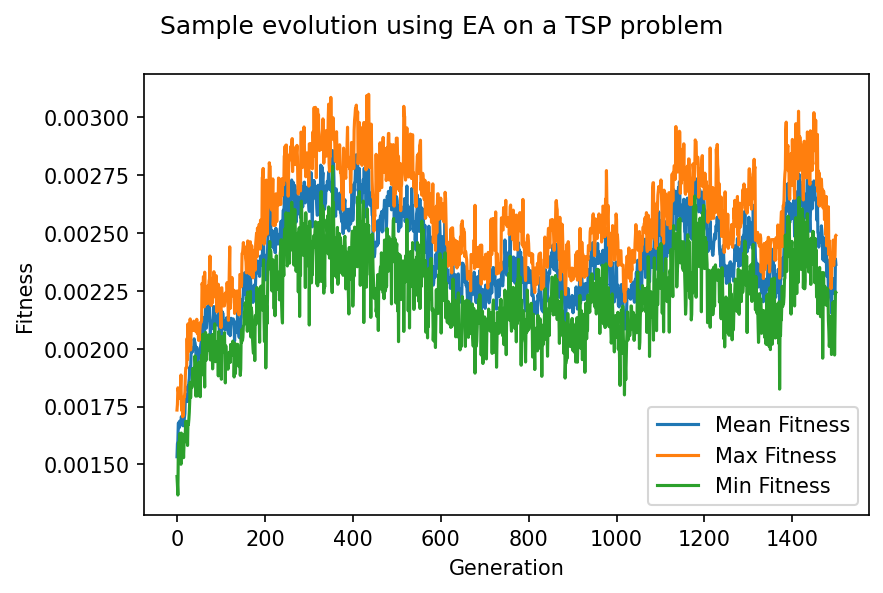

In [8]:
def simple_EA(city_dist:np.ndarray, pop_size:int, max_gen:int, eval_fitness, get_travel_time):
    """
    Runs a simple evolutionary algorithm to find the fittest candidate solution.
    """
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, eval_fitness)[:-1])
    # Probability for mutation
    p_m = 0.1
    # Initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            # Select the two parents that should reproduce using tournament selection
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            # Store the offsprings, the individuals that constitute the population of the next generation
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            # Apply mutation with probability p_m
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
        
        stats.append(eval_population(new_pop, eval_fitness)[:-1])
        # Apply generational replacement strategy
        population = new_pop
        gen += 1
    return population, stats
    

# Get Problem Setup
city_dist = get_map(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
fitness_func, travel_time_func = get_fitness_func(city_dist)
population, stats = simple_EA(city_dist, pop_size, max_gens, fitness_func, travel_time_func)
fig, axs = plt.subplots(1, facecolor='w', sharex=True, sharey=True)
axs.plot(np.arange(max_gens), [stat[0] for stat in stats], label="Mean Fitness")
axs.plot(np.arange(max_gens), [stat[1] for stat in stats], label="Max Fitness")
axs.plot(np.arange(max_gens), [stat[2] for stat in stats], label="Min Fitness")
axs.set_xlabel('Generation')
axs.set_ylabel('Fitness')
axs.legend(loc="best")
fig.suptitle("Sample evolution using EA on a TSP problem")
fig.tight_layout()
fig.set_dpi(150)


[14 20 30 47 49 44 41 36 23 10  6 17 33 38 46 45 28 27 37 42 43 40 48 26
 16  0  8 18 29 24 19 31 21 32  9  3  4 34 25 12 39 35  1  5 15 11  7  2
 22 13]


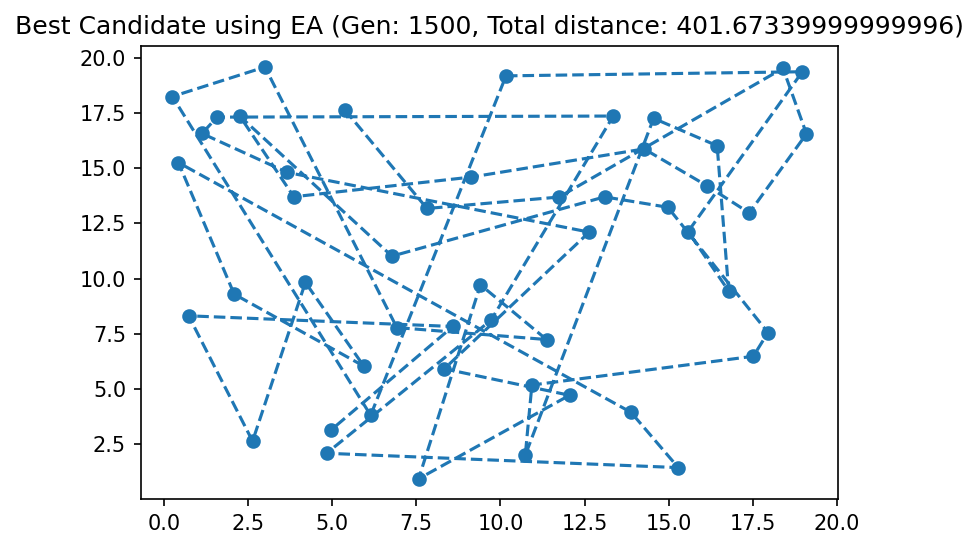

In [9]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, fitness_func)
best_candidate = population[best_idx]
best_travel_time = travel_time_func(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate using EA (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length
of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt)

The 2-opt algorithm was implemented following the mechanisms described in https://en.wikipedia.org/wiki/2-opt.

In [10]:
def two_opt_swap(phen:List[int], i:int, k:int) -> List[int]:
    new_route = np.zeros(len(phen), dtype=int)
    #1. take route[0] to route[i-1] and add them in order to new_route
    new_route[0:i] = phen[0:i]
    #2. take route[i] to route[k] and add them in reverse order to new_route
    new_route[i:k+1] = np.flip(phen[i:k+1])
    #3. take route[k+1] to end and add them in order to new_route
    new_route[k+1:] = phen[k+1:]
    return new_route

def two_opt_search(phen:List[int], eval_fitness) -> List[int]:
    fitness = eval_fitness(phen)
    found_better_phen = False
    while True:
        for i in range(len(phen)-1):
            for k in range(i+1, len(phen)):
                new_phen = two_opt_swap(phen, i, k)
                new_fitness = eval_fitness(new_phen)
                if new_fitness > fitness:
                    phen = new_phen
                    fitness = new_fitness
                    found_better_phen = True 
                    break
            if found_better_phen:
                found_better_phen = False
                break
        # End local search if no progress has been made
        if not found_better_phen:
            break
    return phen

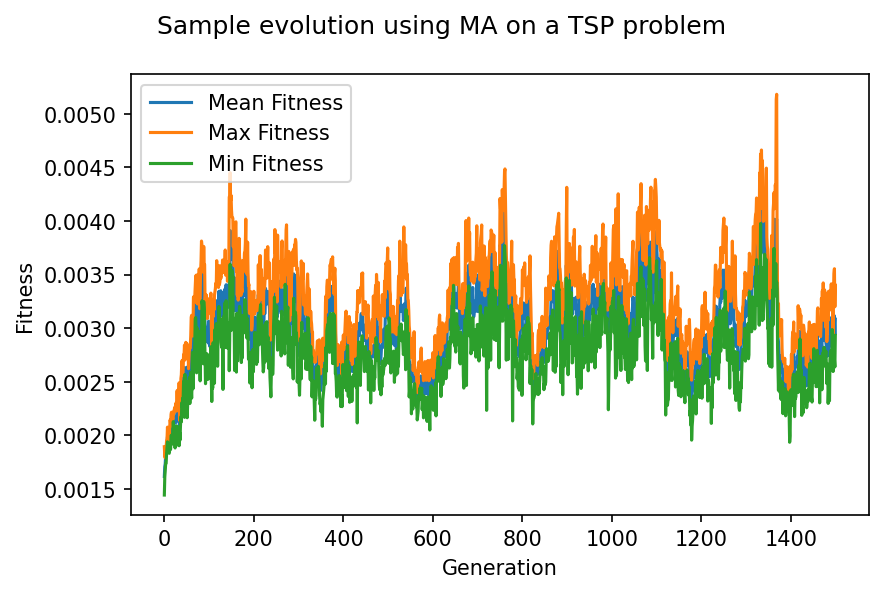

In [11]:
def two_opt_MA(city_dist:np.ndarray, pop_size:int, max_gen:int, eval_fitness, get_travel_time):
    """
    Runs a Memetic Two-Opt Search algorithm to find the fittest candidate solution for a given TSP instance.
    """
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    for i in range(population.shape[0]):
        population[i] = two_opt_search(population[i], eval_fitness)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, eval_fitness)[:-1])
    # Probability for mutation
    p_m = 0.1
    # Initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            # Select the two parents that should reproduce using tournament selection
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            # Store the offsprings, the individuals that constitute the population of the next generation
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            # Apply mutation with probability p_m
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
            new_pop[i] = two_opt_search(new_pop[i], eval_fitness)
            new_pop[i+1] = two_opt_search(new_pop[i], eval_fitness)
        
        stats.append(eval_population(new_pop, eval_fitness)[:-1])
        # Apply generational replacement strategy
        population = new_pop
        gen += 1
    return population, stats

city_dist = get_map(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
fitness_func, travel_time_func = get_fitness_func(city_dist)
population, stats = two_opt_MA(city_dist, pop_size, max_gens, fitness_func, travel_time_func)
fig, axs = plt.subplots(1, facecolor='w')
axs.plot(np.arange(max_gens), [stat[0] for stat in stats], label="Mean Fitness")
axs.plot(np.arange(max_gens), [stat[1] for stat in stats], label="Max Fitness")
axs.plot(np.arange(max_gens), [stat[2] for stat in stats], label="Min Fitness")
axs.set_xlabel('Generation')
axs.set_ylabel('Fitness')
axs.legend(loc="best")
fig.suptitle("Sample evolution using MA on a TSP problem")
fig.tight_layout()
fig.set_dpi(150)

[18  5  2  7 12 13 19 27 29 25 24 17 20 10  4  8  0 16 15 21 31 35 39 45
 40 43 32 30 34 37 49 48 33 46 28 36  9 14  6  3 38 42 41 44 23  1 11 22
 26 47]
6.9223 7.7819


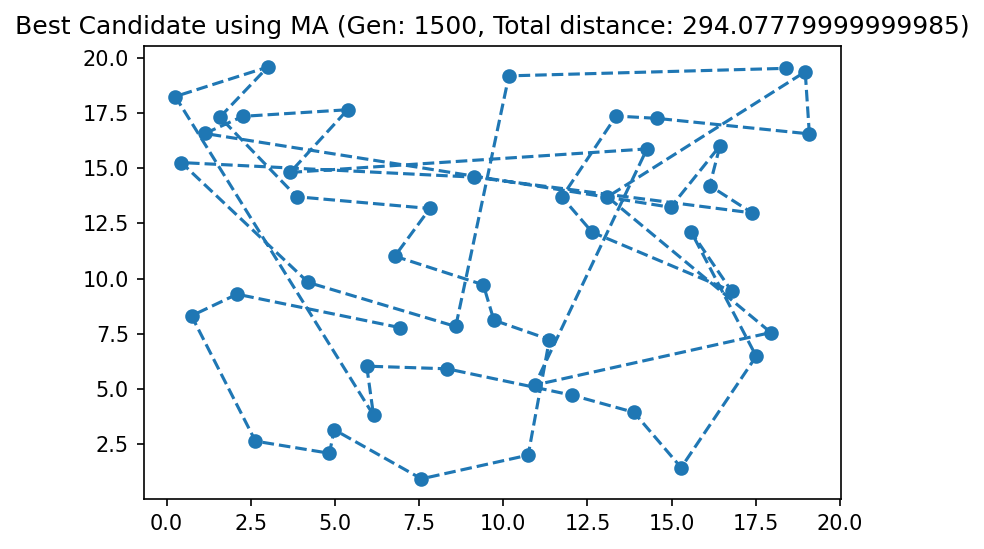

In [12]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, fitness_func)
best_candidate = population[best_idx]
best_travel_time = travel_time_func(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
print(x_coords[0], y_coords[0])
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate using MA (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

(b) Consider the TSP problem instance given in the file ‘file-tsp’. The file ‘file-
tsp’ contains a 50 ×2 matrix with the coordinates (xi,yi) for city i = 1,...,50.
Also, select a small instance at your choice from the ‘Symmetric Traveling Sales-
man Problem’ benchmark instances available at http://elib.zib.de/pub/
mp-testdata/tsp/tsplib/tsplib.html. Run the MA and EA 10 times on
these two problem instances

==> We have decided for the following problem instance: http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/ulysses16.tsp

In [13]:
# Prep problem instance A
city_map = get_map(cities_path)
fitness_func_city, travel_time_city = get_fitness_func(city_map)

# Prep problem instance B
ulysses_map = get_map(ulysses_path)
fitness_func_ulysses, travel_time_ulysses = get_fitness_func(ulysses_map)

pop_size = 10
max_gens = 1500

a_EA_stats = []
a_MA_stats = []
b_EA_stats = []
b_MA_stats = []

# Run both the EA and the MA for both problem instances a and b 
for i in range(10):
    population, stats = simple_EA(city_map, pop_size, max_gens, fitness_func_city, travel_time_city)
    a_EA_stats.append(stats)
    population, stats = two_opt_MA(city_map, pop_size, max_gens, fitness_func_city, travel_time_city)
    a_MA_stats.append(stats)
    population, stats = simple_EA(ulysses_map, pop_size, max_gens, fitness_func_ulysses, travel_time_ulysses)
    b_EA_stats.append(stats)
    population, stats = two_opt_MA(ulysses_map, pop_size, max_gens, fitness_func_ulysses, travel_time_ulysses)
    b_MA_stats.append(stats)

    


(c) For each algorithm (EA and MA), and for each problem instance, provide a
figure containing plots average and best fitness against the elapsed number of
iterations (1500 iterations) for all 10 runs

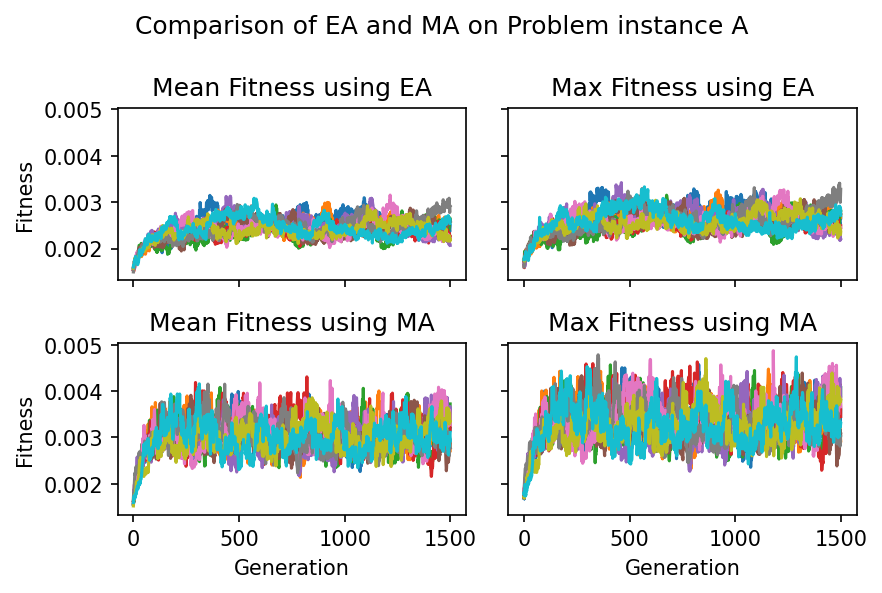

In [17]:
# Plot comparison of EA and MA on Problem instance A
fig, axs = plt.subplots(2, 2, facecolor='w', sharex=True, sharey=True)
for i in range(10):
    axs[0][0].plot(np.arange(max_gens), [stat[0] for stat in a_EA_stats[i]], label=f"Trial {i+1}")
    axs[0][1].plot(np.arange(max_gens), [stat[1] for stat in a_EA_stats[i]], label=f"Trial {i+1}")
    axs[1][0].plot(np.arange(max_gens), [stat[0] for stat in a_MA_stats[i]], label=f"Trial {i+1}")
    axs[1][1].plot(np.arange(max_gens), [stat[1] for stat in a_MA_stats[i]], label=f"Trial {i+1}")
#axs[0][0].legend(loc="best")
#axs[0][1].legend(loc="best")
#axs[1][0].legend(loc="best")
#axs[1][1].legend(loc="best")
axs[0][0].title.set_text("Mean Fitness using EA")
axs[0][1].title.set_text("Max Fitness using EA")
axs[1][0].title.set_text("Mean Fitness using MA")
axs[1][1].title.set_text("Max Fitness using MA")
plt.setp(axs[-1, :], xlabel='Generation')
plt.setp(axs[:, 0], ylabel='Fitness')
fig.suptitle("Comparison of EA and MA on Problem instance A")
fig.tight_layout()
fig.set_dpi(150)

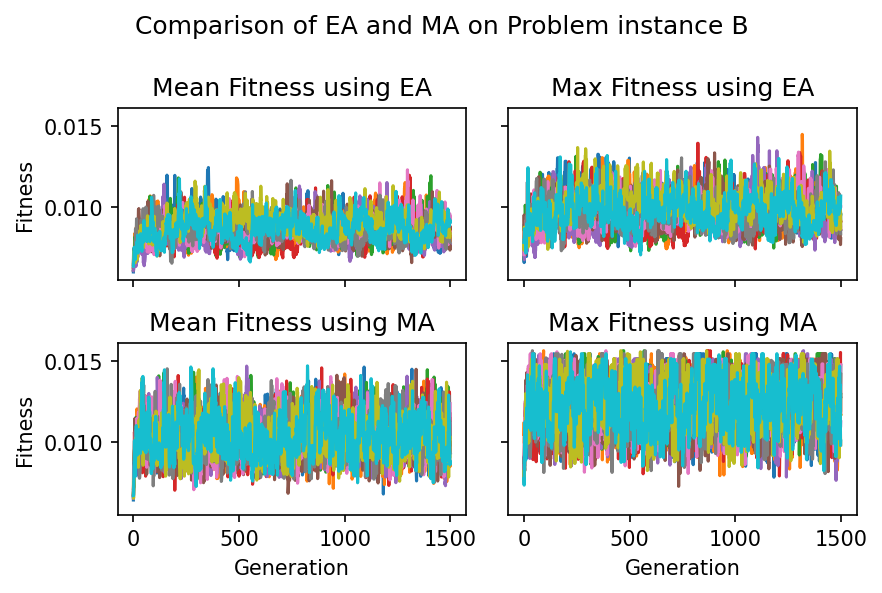

In [16]:
# Plot comparison of EA and MA on Problem instance B
fig, axs = plt.subplots(2, 2, facecolor='w', sharex=True, sharey=True)
for i in range(10):
    axs[0][0].plot(np.arange(max_gens), [stat[0] for stat in b_EA_stats[i]], label=f"Trial {i+1}")
    axs[0][1].plot(np.arange(max_gens), [stat[1] for stat in b_EA_stats[i]], label=f"Trial {i+1}")
    axs[1][0].plot(np.arange(max_gens), [stat[0] for stat in b_MA_stats[i]], label=f"Trial {i+1}")
    axs[1][1].plot(np.arange(max_gens), [stat[1] for stat in b_MA_stats[i]], label=f"Trial {i+1}")
#axs[0][0].legend(loc="best")
#axs[0][1].legend(loc="best")
#axs[1][0].legend(loc="best")
#axs[1][1].legend(loc="best")
axs[0][0].title.set_text("Mean Fitness using EA")
axs[0][1].title.set_text("Max Fitness using EA")
axs[1][0].title.set_text("Mean Fitness using MA")
axs[1][1].title.set_text("Max Fitness using MA")
plt.setp(axs[-1, :], xlabel='Generation')
plt.setp(axs[:, 0], ylabel='Fitness')
fig.suptitle("Comparison of EA and MA on Problem instance B")
fig.tight_layout()
fig.set_dpi(150)

(d) Compare the plots of the two algorithms. Which method (EA or MA) works
best?

It is obvious from the plots, that the MA consistently outperforms the EA. 

On problem instance A, we see that the EA finds solutions with a fitness close to 0.003. The MA, on the other hand, consistently finds solutions around 0.004 and even gets as high as 0.005.

Problem instance B provides analogous results. While the difference is not as drastic as in A, we see that the MA generally finds solutions with higher fitness as both the mean and the max fitness are consistently higher than with EA.

(e) Do you consider the above comparison of the MA and EA algorithms (based on
their results over the same number of iterations) fair? Justify your answer. If
your answer is no, then explain what a fair comparison could be.

We would not consider the comparison as fair. The reason for this is, that the number of search steps that the MA takes is far greater than the number of search steps done by the EA. This is because the MA does the same search steps as the EA, but on top of that also performs local search steps on every individual to find locally optimal solutions. A fair comparison between approaches should ideally have the same number of search steps performed.

Though you can make a case for it being a fair comparison in the sense that both run through the same number of iterations. In that case, however, one would also have to consider the time per iteration etc. in a fair comparison.

(f) In general, on the TSP problem, are memetic algorithms more effective than
simple EAs? (To answer this question, please rely on (recent) results from the
literature, and include references to the papers used to answer this question).

Generally speaking, Memetic Algorithms have proven to be more effective on the TSP problem.

One example for this is the NMGA proposed in (Arindam et al, 2019). In the results of their experiments, it is stated that: "[..] The percentage of error [e: To the benchmark solution] is lesser in NMGA than the classical standard GA. Here, 53 standard instances from 7 to 318 cities are studied and most of the cases NMGA produced better results."




References

[Roy, Arindam, Apurba Manna, and Samir Maity. "A novel memetic genetic algorithm for solving traveling salesman problem based on multi-parent crossover technique." Decision Making: Applications in Management and Engineering 2.2 (2019): 100-111.]